### Convex Adjustment:Q Theory 
$$
V(A,K)=\max_{0\leq K'\leq AK^\alpha+(1-\delta)K}\{AK^\alpha-\frac{\gamma}{2}(\frac{K'-(1-\delta)K}{K})^2K-p(K'-(1-\delta)K)+\beta E_{A'|A}V(A',K')\}\\
s.t. \ A' = \rho A +\epsilon
$$
### Nonconvex Adjustment
$$
V(A,K)=\max\{V^a(A,K),V^i(A,K)\}\\
V^a(A,K)=\max_{0\leq K'\leq AK^\alpha+(1-\delta)K}\{AK^\alpha-FK-p(K'-(1-\delta)K)+\beta E_{A'|A}V(A',K')\}\\
V^i(A,K)=AK^\alpha+\beta E_{A'|A}V(A',(1-\delta)K)\\
s.t. \ A' = \rho A +\epsilon
$$
### Mixed model
$$
V(A,K)=\max\{V^b(A,K),V^s(A,K),V^i(A,K)\}\\
V^b(A,K)=\max_{(1-\delta)K\leq K'\leq AK^\alpha+(1-\delta)K}\{AK^\alpha-FK-\frac{\gamma}{2}(\frac{K'-(1-\delta)K}{K})^2K-p(K'-(1-\delta)K)+\beta E_{A'|A}V(A',K')\}\\
V^s(A,K)=\max_{0\leq K'\leq (1-\delta)K}\{AK^\alpha-FK-\frac{\gamma}{2}(\frac{(1-\delta)K-K'}{K})^2K+p_s((1-\delta)K-K')+\beta E_{A'|A}V(A',K')\}\\
V^i(A,K)=AK^\alpha+\beta E_{A'|A}V(A',(1-\delta)K)\\
s.t. \ A' = \rho A +\epsilon
$$

In [1]:
%matplotlib inline
from __future__ import division
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fminbound
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import random as rd
from scipy.optimize import fsolve,bisect

In [2]:
class Investment0(object):
    def __init__(self, beta=0.95, delta = 0.069, gamma = 0.125, alpha = 0.51,p = 1,F = 0.0333,
                     transition = [[.5,.5],[.5,.5]], shocks = [.9, 1.1],grid_max=50,
                     grid_min = .1, grid_size=200):

        self.delta, self.beta, self.gamma,self.alpha,self.p,self.F = delta, beta, gamma,alpha,p,F
        self.shocks = shocks
        self.transition = np.asarray(transition)

        self.grid = np.linspace(grid_min, grid_max, grid_size)

        if len(self.transition) != len(self.shocks):
            self.transition = [[1/len(self.shocks)]*len(self.shocks)]*len(self.shocks)

        for j in range(len(self.transition)):
            self.transition[j] = [max(k, 0) for k in self.transition[j]]
            self.transition[j] /= np.asarray(list(self.transition[j])).sum()
            if np.asarray(self.transition[j]).sum() == 0:
                self.transition[j] = np.asarray([1/len(self.transition)]*len(self.transition))
        self.transition = np.asarray(self.transition)

    def bellman_operator1(self, w):

        Aw = [InterpolatedUnivariateSpline(self.grid, w[i]) for i in range(len(self.shocks))]
        Awx = lambda y: np.asarray([function(y) for function in Aw])
        sigma = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        Tw = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        for i, x in enumerate(self.grid):
            for j, e in enumerate(self.shocks):
                
                adjcost = lambda k: -e*x**self.alpha+self.gamma*x*(k/x-1+self.delta)**2/2+self.p*(k-(1-self.delta)*x)-self.beta*np.dot(self.transition[j],Awx(k))
                a_star = fminbound(adjcost,1e-6,1e-6+e*x**self.alpha+(1-self.delta)*x)
                Tw[j][i] =  -adjcost(a_star)
                sigma[j][i] = a_star


        return Tw, sigma
    
    def bellman_operator2(self, w):

        Aw = [InterpolatedUnivariateSpline(self.grid, w[i]) for i in range(len(self.shocks))]
        Awx = lambda y: np.asarray([function(y) for function in Aw])
        sigma = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        Tw = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        flag = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        change = np.empty([3,2])
        for i, x in enumerate(self.grid):
            for j, e in enumerate(self.shocks):
                
                fixcost = lambda k: -e*x**self.alpha+self.F*x+self.p*(k-(1-self.delta)*x)-self.beta*np.dot(self.transition[j],Awx(k))
                f_star = fminbound(fixcost,1e-6,1e-6+e*x**self.alpha+(1-self.delta)*x)
                inaction = e*x**self.alpha+self.beta*np.dot(self.transition[j],Awx((1-self.delta)*x))
                buy_max = -fixcost(f_star)
                Tw[j][i] =  max(buy_max,inaction)
                
                if Tw[j][i] == buy_max:
                    sigma[j][i] = f_star
                    flag[j][i] = 1
                else:
                    sigma[j][i] = (1-self.delta)*x
                    flag[j][i] = 0
                    
                   
                
        return Tw, sigma,flag

    def solve_stable(self):
        stable_true_1 = np.zeros(len(self.shocks))
        stable_true_2 = np.zeros(len(self.shocks))
        for j, e in enumerate(self.shocks):
            f = lambda k:self.gamma*self.delta+self.p+self.beta*(-self.p*(1-self.delta)+(self.delta**2-2*self.delta)*self.gamma/2-np.dot(self.transition[j],self.shocks.T*self.alpha*k**(self.alpha-1)))
            g = lambda k:self.p+self.beta*(-self.p*(1-self.delta)+self.F-np.dot(self.transition[j],self.shocks.T*self.alpha*k**(self.alpha-1)))
            stable_true_1[j] = fsolve(f, x0=1)
            stable_true_2[j] = fsolve(g, x0=1) 
        return stable_true_1,stable_true_2

In [3]:
def compute(cp):
    return ((2*cp.delta-cp.delta**2-cp.delta/cp.beta)*cp.gamma/(cp.alpha*(2/cp.beta-2+2*cp.delta)))**(cp.alpha-1)

In [4]:
def approx_markov(rho, sigma_u,u = 0, m=3, n=7):
        F = norm(loc=0, scale=sigma_u).cdf

        #  y_t标准差
        std_y = np.sqrt(sigma_u**2 / (1-rho**2))
        # top of discrete state space
        x_max = m * std_y
        # bottom of discrete state space
        x_min = - x_max
        # discretized state space
        x = np.linspace(u+x_min, u+x_max, n)

        step = (x_max - x_min) / (n - 1)
        half_step = 0.5 * step
        P = np.empty((n, n))

        for i in range(n):
            P[i, 0] = F(x[0]-rho * x[i] + half_step)
            P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
            for j in range(1, n-1):
                z = x[j] - rho * x[i]
                P[i, j] = F(z + half_step) - F(z - half_step)

        return x, P

In [5]:
def compute_fixed_point(T, v, error_tol=1e-3, max_iter=500,
                            print_skip=25,verbose=True):#迭代计算
        i = 0
        error = error_tol + 1

        while i < max_iter and error > error_tol:
            new_v = T(v)[0]
            i += 1
            error = np.max(np.abs(new_v - v))
            if verbose and i % print_skip == 0:
                print(f"第 {i}步收敛结果是  {error}.")
                
            v = new_v
        if i == max_iter:
            print("收敛失败")
        if verbose and i < max_iter:
            print(f"\n在第 {i} 步收敛")


        return v

In [6]:
epsilon, trans = approx_markov(rho = .106, sigma_u=.855, n = 3, m=0.6)
shocklist = np.exp(epsilon)

print(trans,shocklist)

[[0.40604161 0.23664902 0.35730937]
 [0.38144048 0.23711903 0.38144048]
 [0.35730937 0.23664902 0.40604161]] [0.59695918 1.         1.67515643]


In [7]:
cp0 = Investment0(gamma = 0.125,transition=trans,shocks=shocklist)
cp0.solve_stable()
# compute(cp0)
# np.dot(cp0.transition[0],cp0.shocks)

(array([21.44015301, 22.51778162, 23.62783061]),
 array([13.24983465, 13.91580009, 14.60180105]))

In [8]:
%%time

# w_guess = np.asarray([np.log(cp.grid)]*len(cp.shocks))
w_guess = np.zeros((len(cp0.shocks),len(cp0.grid)))
# w_guess

w_star1 = compute_fixed_point(cp0.bellman_operator1, w_guess, max_iter=500, verbose=1, error_tol=1e-3, print_skip=20)

第 20步收敛结果是  1.0215586833993768.
第 40步收敛结果是  0.36621365441772014.
第 60步收敛结果是  0.13128243970191988.
第 80步收敛结果是  0.04706290649262712.
第 100步收敛结果是  0.016871389445256568.
第 120步收敛结果是  0.006048155607643935.
第 140步收敛结果是  0.002168178641937857.

在第 156 步收敛
Wall time: 1min 31s


In [9]:
%%time
w_star2 = compute_fixed_point(cp0.bellman_operator2, w_guess, max_iter=500, verbose=1, error_tol=1e-3, print_skip=20)

第 20步收敛结果是  0.9771924032343833.
第 40步收敛结果是  0.3475113657206492.
第 60步收敛结果是  0.12401409130080765.
第 80步收敛结果是  0.04429371575692187.
第 100步收敛结果是  0.015842187278224173.
第 120步收敛结果是  0.005670983067290081.
第 140步收敛结果是  0.002031500302933864.

在第 154 步收敛
Wall time: 2min 4s


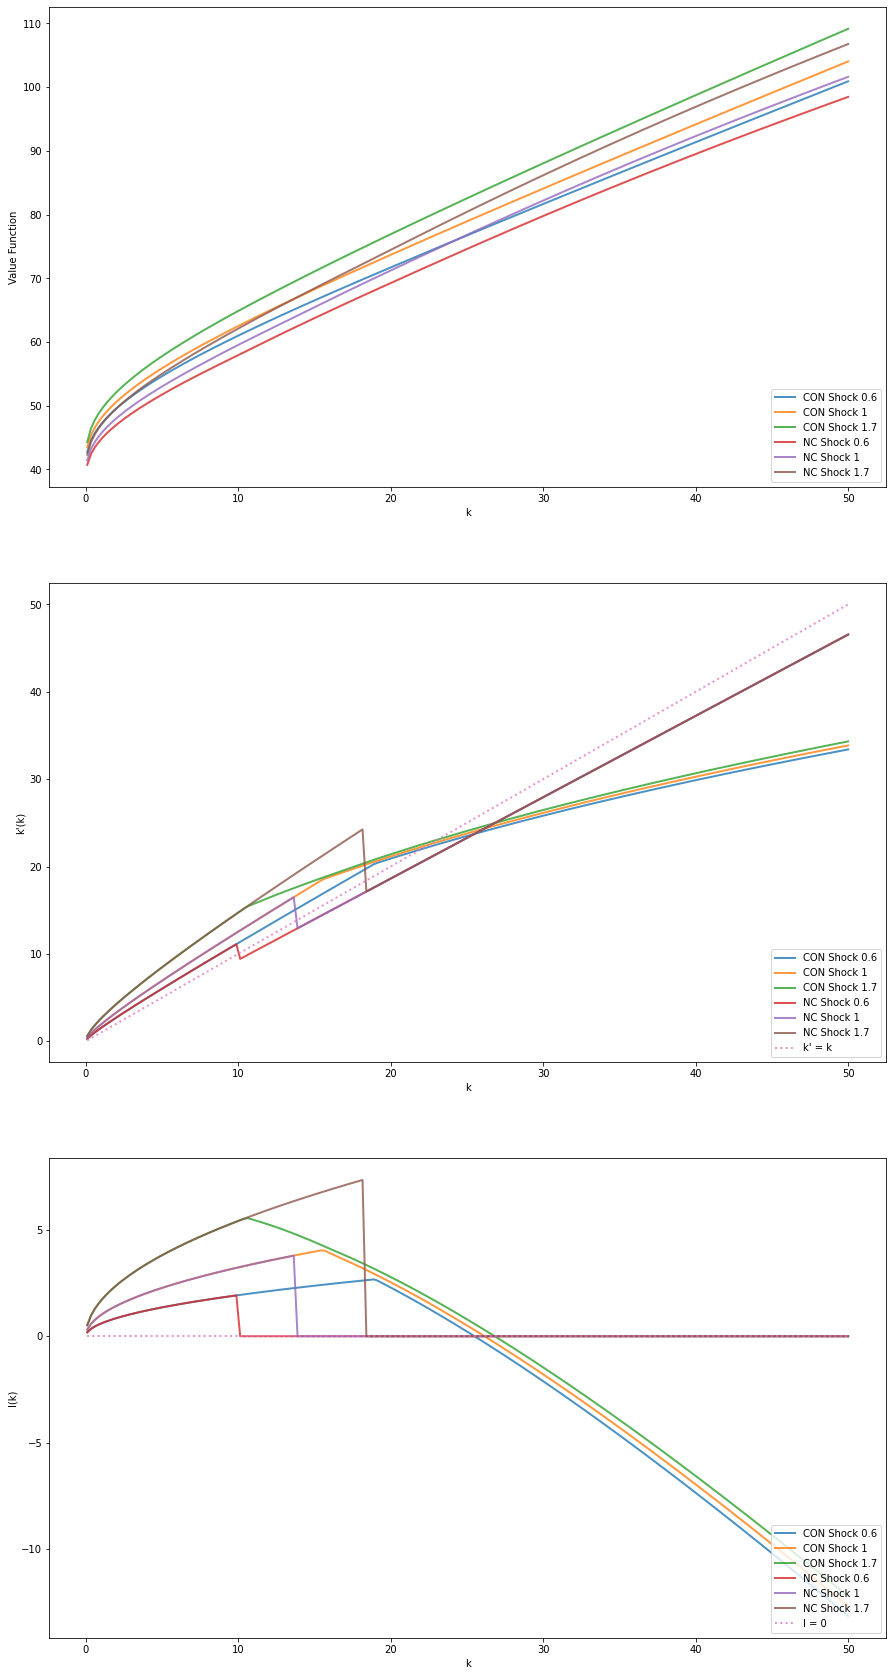

In [10]:
sigma_star1 = cp0.bellman_operator1(w_star1)[1]
sigma_star2 = cp0.bellman_operator2(w_star2)[1]

fig, ax = plt.subplots(3, 1, figsize =(15,30))
ax[0].set_xlabel("k")
ax[1].set_xlabel("k")
ax[2].set_xlabel("k")
ax[0].set_ylabel("Value Function")
ax[1].set_ylabel("k'(k)")
ax[2].set_ylabel("I(k)")
labels1 = [r'CON Shock {0:.2g}'.format(cp0.shocks[k]) for k in range(len(cp0.shocks))] # Label "Shock 1", "Shock 2"
labels2 = [r'NC Shock {0:.2g}'.format(cp0.shocks[k]) for k in range(len(cp0.shocks))] # Label "Shock 1", "Shock 2"
for i in range(len(cp0.shocks)):
    ax[0].plot(cp0.grid, w_star1[i], lw = 2, alpha = .8, label= labels1[i])
for i in range(len(cp0.shocks)):
    ax[1].plot(cp0.grid, sigma_star1[i], alpha = .8, lw = 2,  label= labels1[i])
for i in range(len(cp0.shocks)):
    ax[2].plot(cp0.grid, sigma_star1[i]-(1-cp0.delta)*cp0.grid, alpha = .8, lw = 2,  label= labels1[i])
for i in range(len(cp0.shocks)):
    ax[0].plot(cp0.grid, w_star2[i], lw = 2, alpha = .8, label= labels2[i])
for i in range(len(cp0.shocks)):
    ax[1].plot(cp0.grid, sigma_star2[i], alpha = .8, lw = 2,  label= labels2[i])
for i in range(len(cp0.shocks)):
    ax[2].plot(cp0.grid, sigma_star2[i]-(1-cp0.delta)*cp0.grid, alpha = .8, lw = 2,  label= labels2[i])   

ax[1].plot(cp0.grid,cp0.grid, alpha = .8, lw = 2,  label= "k' = k",linestyle=":")
ax[2].plot(cp0.grid,np.zeros(len(cp0.grid)), alpha = .8, lw = 2,  label= "I = 0",linestyle=":")
ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')
ax[2].legend(loc = 'lower right')


In [40]:
def simulation(cp,sigma_star,cap,n,a,b):

    sigma = [InterpolatedUnivariateSpline(cp.grid,sigma_star[i] ) for i in range(len(cp.shocks))]
    stable = np.empty(len(cp.shocks))

    for i in range(len(cp.shocks)):
        f = lambda k: sigma[i](k)-k
        stable[i] = bisect(f,a,b)

    kk = np.zeros(n+1)
    inv = np.zeros(n)
    ii = np.zeros(n)
    state = np.zeros(n+1)
    ident = np.array(trans)
    for i in range (0,3):
        for j in range (1,3):
            ident[i][j] = trans[i][j] + ident[i][j-1]
    state[0] = 1
    
    fig, ax = plt.subplots(3, 1, figsize =(15,30))

    ax[0].set_xlabel("t")
    ax[1].set_xlabel("t")
    ax[2].set_xlabel("t")
    ax[0].set_ylabel("K")
    ax[1].set_ylabel("investment rate")
    ax[2].set_ylabel("state")


    
    for p in range(len(cap)):
        kk[0] = cap[p]
        for i in range(0,n):
            flag = rd.random()
            for j in range(0,3):
                if flag < ident[int(state[i])][j]:
                    kk[i+1] = sigma[j](kk[i])
                    state[i+1] = j
                    break

            inv[i]=kk[i+1]-(1-cp.delta)*kk[i]
            ii[i] = inv[i]/kk[i]


        caplab = r'start = {0:.2f}'.format(cap[p])
        ax[0].plot(np.arange(0,n+1),kk, alpha = .8,label = caplab, lw = 2,)
        ax[1].plot(np.arange(0,n),ii, alpha = .8, label = caplab, lw = 2)
        ax[2].plot(np.arange(0,n+1),state, alpha = .8, label = caplab, lw = 2)
        
#     ax[1].legend(loc = 'lower right')
#     ax[2].legend(loc = 'lower right')

    labels = [r'Stable = {0:.2f}'.format(stable[k]) for k in range(len(cp.shocks))] # Label "Shock 1", "Shock 2"
    for i in range(len(cp.shocks)):
        ax[0].plot(np.arange(0,n), stable[i]*np.ones(n), alpha = .8, lw = 2,  label= labels[i],linestyle = ":") 
    ax[0].legend(loc = 'lower right')
    ax[1].legend(loc = 'lower right')
    ax[2].legend(loc = 'lower right')
    plt.show()


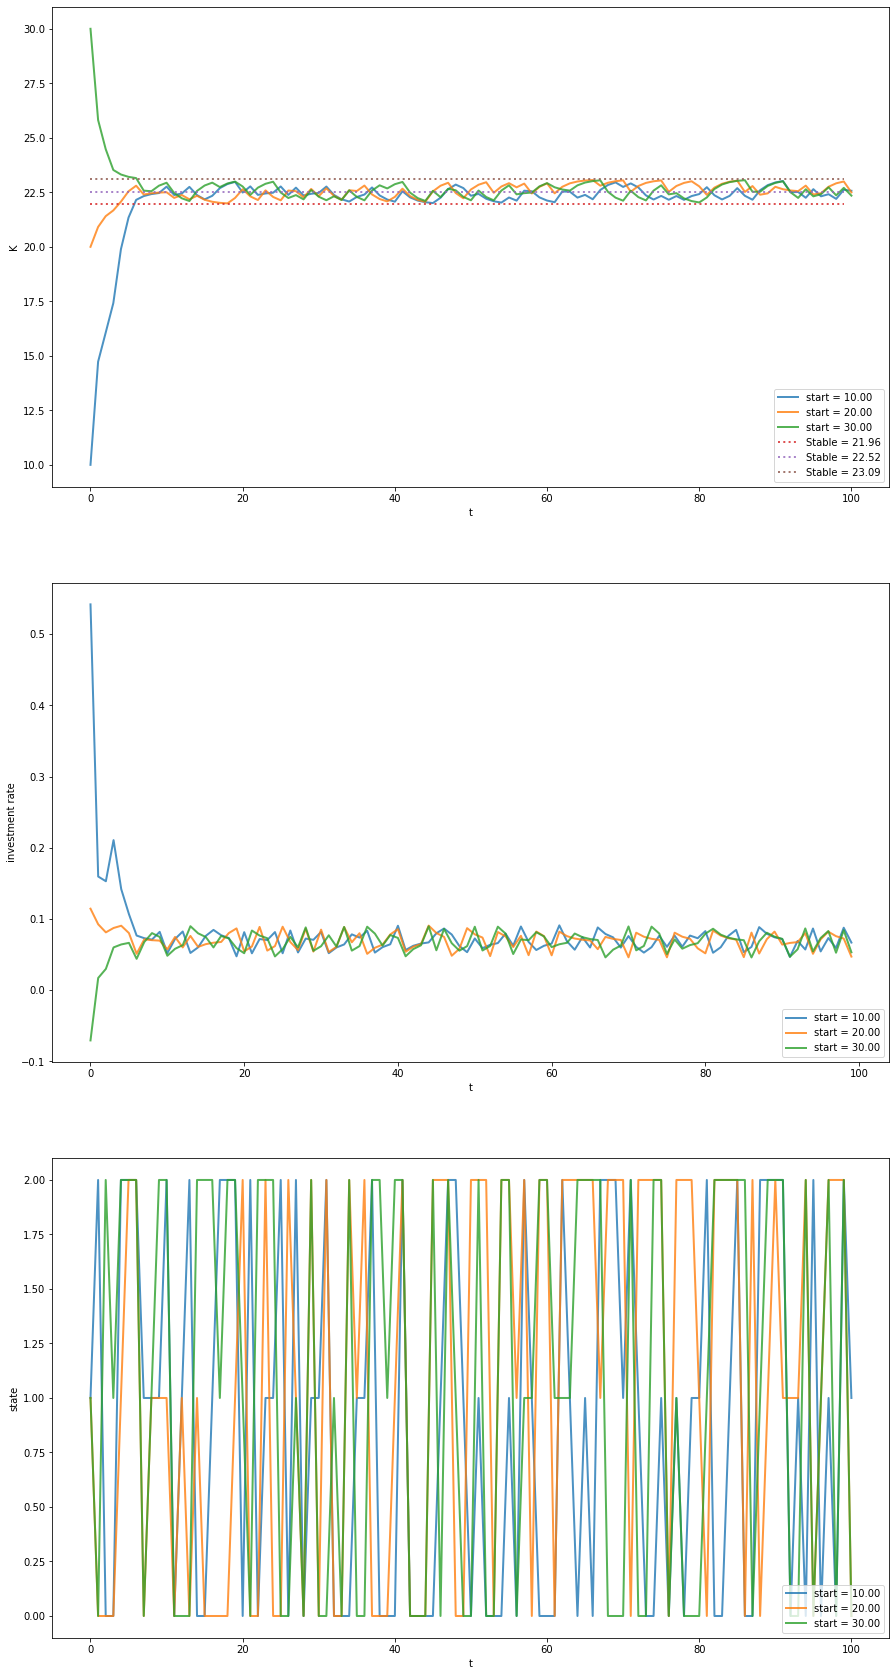

In [41]:
simulation(cp0,sigma_star1,(10,20,30),100,10,30)

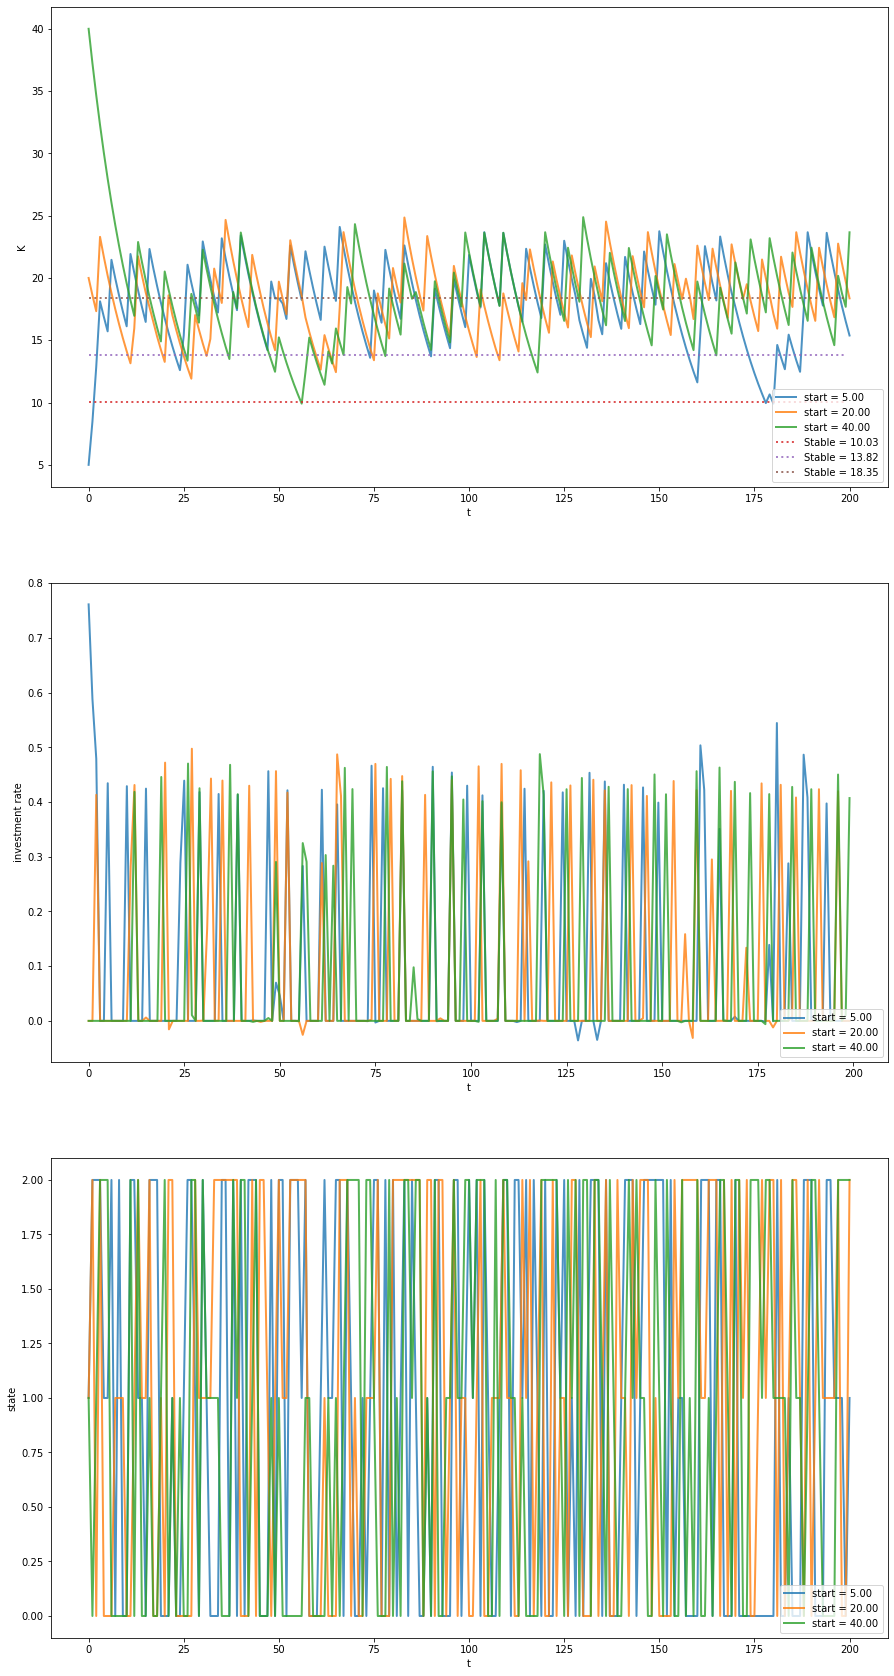

In [43]:
simulation(cp0,sigma_star2,(5,20,40),200,5,30)

In [39]:
flag2 = cp0.bellman_operator2(w_star2)[2]
for j in range(0,3):
    for i in range(0,200):
        if(flag2[j][i] == 0):
            print(j,cp0.grid[i],sigma_star2[j][i],sigma_star2[j][i-1])
            break

0 10.130150753768845 9.431170351758796 11.11751877828841
1 13.891457286432162 12.932946733668343 16.490603890444703
2 18.405025125628143 17.1350783919598 24.249038221862072


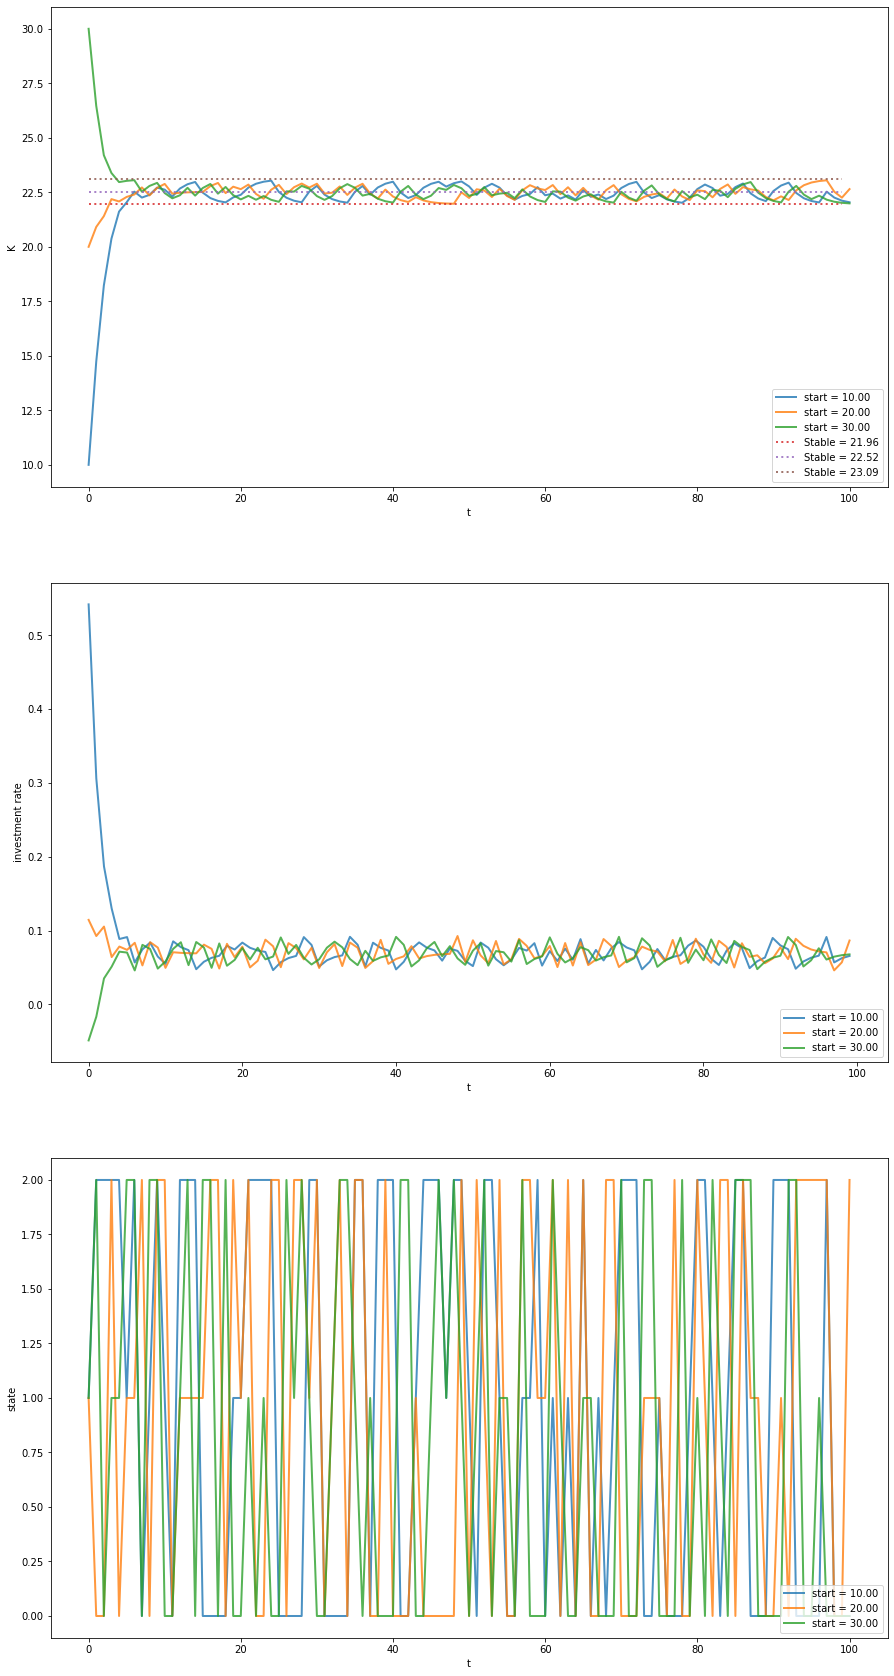

In [45]:
simulation(cp0,sigma_star1,(10,20,30),100,10,30)